### FOM study via isaura data for LPR


You must choose the file inserted here for this to work

In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [2]:
#adding here ROI
emin = 1.55
emax = 1.65

#### Collecting all the data

In [3]:

# list of all files in a folder
folder_path = '../LPR_rerun_voxel/isaura_10x10x10mm/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also

In [4]:
print("Tracks: ")
display(tracks.tail())
print(tracks['event'].nunique())
print("")
print("MC data")
display(particles.tail())
print("")
print("Event map:")
display(eventmap.head())

Tracks: 


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
258315,4060708,1,0.121964,14.142136,3,1244,3,184.675,346.675,305.074768,...,309.084361,199.819036,352.583988,308.110573,0.121964,0.121964,0.121964,10.000000,10.000000,9.859631
258316,4060708,2,0.033485,10.000000,2,144,3,153.675,366.675,386.938629,...,389.045441,162.594082,366.980910,390.887885,0.033485,0.033472,0.033472,10.000000,10.000000,9.859631
258317,4060710,0,0.572125,44.565517,36,7243,1,315.675,294.675,522.397217,...,532.700813,331.038243,299.916212,527.865748,0.279909,0.256440,0.002211,9.833333,9.428571,8.912888
258318,4060712,0,0.888838,109.999957,76,6895,2,-6.325,415.675,335.498718,...,352.800524,25.058429,476.143700,418.546023,0.688630,0.026967,0.000000,9.500000,8.875000,9.673330
258319,4060712,1,0.000585,0.000000,1,18,2,65.675,424.675,350.184662,...,350.184662,67.733877,426.232716,350.184662,0.000585,0.000585,0.000585,9.500000,8.875000,9.673330


100009

MC data


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.0,0.0,0.0,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.0,-0.0,-0.0,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.0,0.0,-0.0,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.0,0.0,-0.0,0.033170,1.671516,eIoni,eIoni
8041800,2030356,53,Pb208,False,36,396.074768,394.611877,530.918335,0.000739,396.078827,...,2.427084,-0.653481,0.719626,0.0,-0.0,0.0,0.000018,0.004373,RadioactiveDecay,NoProcess



Event map:


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008


#### Checking that the MC data indexing is just half the track index, and matching the indices accordingly

In [5]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

,nexus_evt,evt_number
0,2540000,5080000
1,2540001,5080002
2,2540002,5080004
3,2540003,5080006
4,2540004,5080008
...,...,...
100004,2030352,4060704
100005,2030353,4060706
100006,2030354,4060708
100007,2030355,4060710


No Falses to be seen!


In [6]:
# So we're updating it here
particles['event_id'] = particles['event_id'] * 2 
display(particles.head())

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot


#### Select a specific event just to check for anything weird happening

In [7]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 5080004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
7,5080004,0,0.475175,33.603286,13,4183,4,12.675,-315.325,147.604263,...,151.930309,19.101046,-292.754173,153.639171,0.371749,0.309839,0.206413,10.0,9.222222,7.255455
8,5080004,1,0.000826,0.000000,1,28,4,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,10.0,9.222222,7.255455
9,5080004,2,0.000476,0.000000,1,21,4,22.675,-336.325,159.047852,...,159.047852,24.360200,-334.110790,159.047852,0.000476,0.000476,0.000476,10.0,9.222222,7.255455
10,5080004,3,0.000204,0.000000,1,12,4,69.675,-285.325,153.809357,...,153.809357,71.210282,-284.312488,153.809357,0.000204,0.000204,0.000204,10.0,9.222222,7.255455


#### Starting the cuts here

The below cell includes all the required functions for cutting and beyond

In [8]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency




def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False, log = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (log == True):
        plt.yscale('log')
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return




def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df




def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1




def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

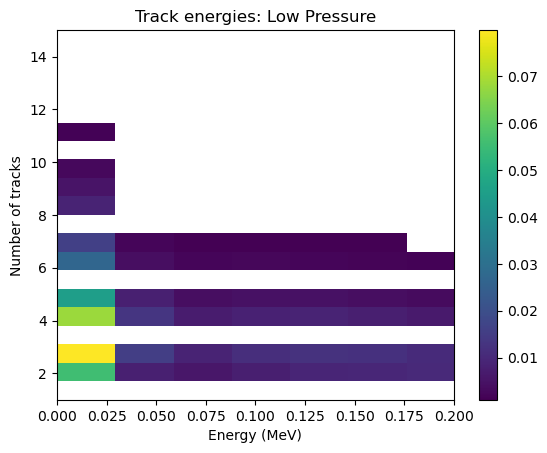

In [9]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 20), cmin=0.001)
plt.xlim([0,0.2])
plt.title("Track energies: Low Pressure")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.colorbar()
plt.show()

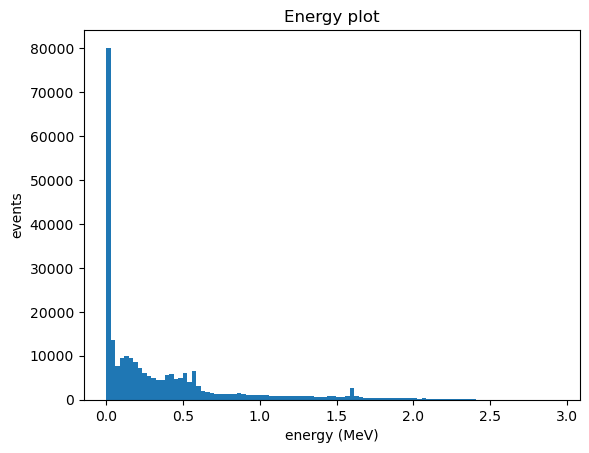

In [13]:
plot_hist(tracks, binning=100)

### Remove low energy events

In [13]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

##### Cuts

We want to:
- Remove low energy events (as shown above)
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV


### Low energy cut

In [14]:
# Low energy cut
display(tracks.head(10))
low_e_cut_tracks = remove_low_E_events(tracks)
display(low_e_cut_tracks.head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.051154,121.454061,104,11063,2,368.675,160.675,334.439758,...,358.948175,381.376657,256.794897,408.658585,0.483891,0.015104,0.000000,9.857143,9.928571,9.619794
1,5080000,1,0.013352,9.928571,2,71,2,388.675,270.675,440.460083,...,442.236380,390.287922,283.647294,446.131930,0.013352,0.013352,0.013352,9.857143,9.928571,9.619794
2,5080002,0,1.768218,136.325163,128,11033,5,-98.325,361.675,587.473511,...,613.110772,-6.622819,382.940215,589.840154,0.162713,0.073897,0.000000,9.750000,9.571429,9.902647
3,5080002,1,0.309468,112.683992,31,1829,5,52.675,348.675,498.257599,...,502.310940,54.698632,349.802676,526.248103,0.162199,0.021946,0.000000,9.750000,9.571429,9.902647
4,5080002,2,0.019542,13.772242,2,4,5,18.675,351.675,555.981140,...,563.299622,27.644104,359.876147,555.981140,0.019542,0.019542,0.019542,9.750000,9.571429,9.902647
5,5080002,3,0.008122,0.000000,1,37,5,28.675,410.675,618.963989,...,620.147517,34.523942,415.043112,620.147517,0.008122,0.008122,0.008122,9.750000,9.571429,9.902647
6,5080002,4,0.000267,0.000000,1,4,5,163.675,337.675,502.410492,...,502.410492,164.174985,338.673183,502.410492,0.000267,0.000267,0.000267,9.750000,9.571429,9.902647
7,5080004,0,0.475175,33.603286,13,4183,4,12.675,-315.325,147.604263,...,151.930309,19.101046,-292.754173,153.639171,0.371749,0.309839,0.206413,10.000000,9.222222,7.255455
8,5080004,1,0.000826,0.000000,1,28,4,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,10.000000,9.222222,7.255455
9,5080004,2,0.000476,0.000000,1,21,4,22.675,-336.325,159.047852,...,159.047852,24.360200,-334.110790,159.047852,0.000476,0.000476,0.000476,10.000000,9.222222,7.255455


/tmp/ipykernel_37947/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,121.454061,104,11063,1,368.675,160.675,334.439758,...,358.948175,381.376657,256.794897,408.658585,0.483891,0.015104,0.000000,9.857143,9.928571,9.619794
2,5080002,0,1.796149,136.325163,128,11033,2,-98.325,361.675,587.473511,...,613.110772,-6.622819,382.940215,589.840154,0.162713,0.073897,0.000000,9.750000,9.571429,9.902647
3,5080002,1,0.309468,112.683992,31,1829,2,52.675,348.675,498.257599,...,502.310940,54.698632,349.802676,526.248103,0.162199,0.021946,0.000000,9.750000,9.571429,9.902647
7,5080004,0,0.476680,33.603286,13,4183,1,12.675,-315.325,147.604263,...,151.930309,19.101046,-292.754173,153.639171,0.371749,0.309839,0.206413,10.000000,9.222222,7.255455
11,5080008,0,0.342280,16.484468,8,2861,2,214.675,211.675,251.550385,...,256.663612,227.209801,223.260120,266.541811,0.312121,0.312061,0.312061,9.166667,9.684211,9.691542
12,5080008,1,0.115869,13.700727,4,1023,2,241.675,346.675,439.461395,...,442.883644,245.679293,360.221708,446.314955,0.115869,0.115869,0.115869,9.166667,9.684211,9.691542
14,5080010,0,1.271544,73.387241,66,10049,2,-88.325,56.675,1118.789551,...,1135.595039,-51.756468,61.706668,1157.252430,0.526127,0.083108,0.000000,9.222222,9.942857,9.929548
15,5080010,1,0.142156,9.222222,2,1120,2,-84.325,355.675,578.050293,...,583.134599,-72.652758,360.711353,582.166985,0.142156,0.142156,0.142156,9.222222,9.942857,9.929548
20,5080012,0,1.294261,210.364839,148,7213,4,-382.325,43.675,368.061554,...,471.658156,-358.444062,59.987005,380.181990,0.108576,0.092052,0.000000,9.772727,9.724138,9.972322
21,5080012,1,0.823952,53.575574,32,4042,4,-352.325,73.675,550.741455,...,571.824162,-347.663709,79.239988,554.679681,0.336033,0.332536,0.000000,9.772727,9.724138,9.972322


54864


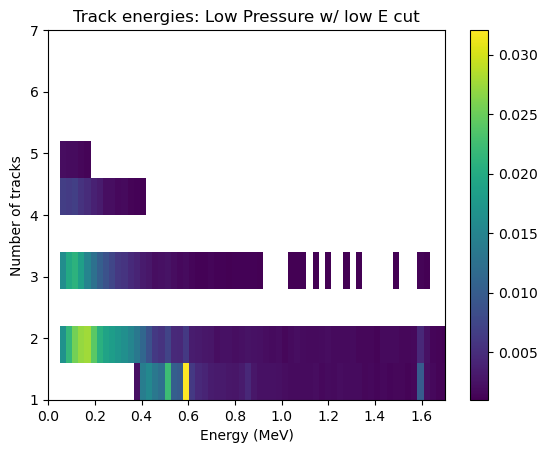

In [15]:
print(len_events(low_e_cut_tracks))

track_energy = low_e_cut_tracks.energy
track_no = low_e_cut_tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()

In [16]:
# Efficiency calculation
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))


# low energy cut
cut_names.append("low E cuts")

# make efficiency calculation
print("Low E cut")
print("==================")
ef = cut_effic(low_e_cut_tracks, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(low_e_cut_tracks))
abs_cut_effics.append(ef)

Low E cut
Efficiency: 54.86 %


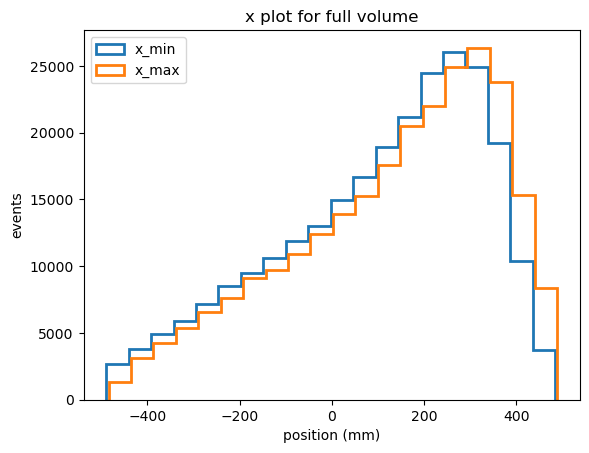

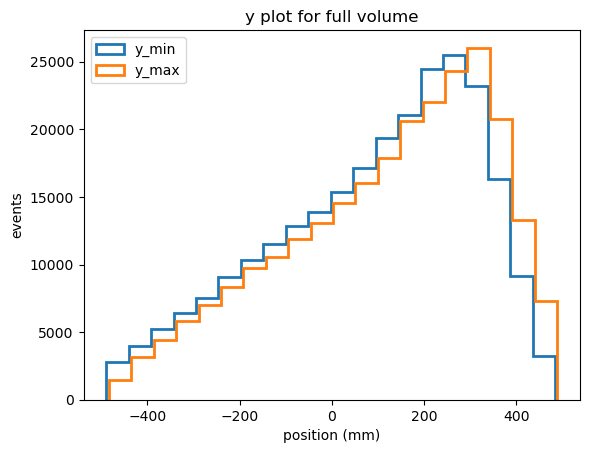

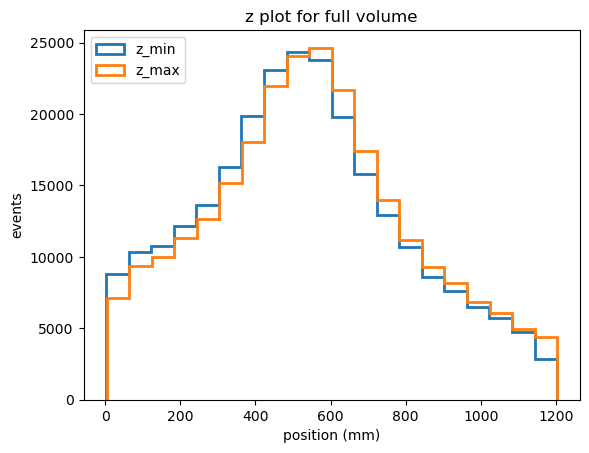

In [17]:
# plotting the positional histograms
plot_volume_hists(tracks)

# Fiducial cuts

In [18]:


cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial_rel = fiducial_track_cut_2(low_e_cut_tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = False)

fiducial_abs = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
print("Fiducial track cut")
print("==================")
print("Relative Cut efficiency:")
ef = cut_effic(fiducial_rel, low_e_cut_tracks)
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial_rel))

print('Absolute Cut efficiency:')
ef = cut_effic(fiducial_abs, tracks)
abs_cut_effics.append(ef)


Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 71.74 %
Absolute Cut efficiency:
Efficiency: 66.85 %


# One track cut

In [19]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial_rel, verbose = False)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Single track cut
Relative Cut efficiency:
Efficiency: 49.85 %
Absolute Cut efficiency:
Efficiency: 25.30 %


# Overlapping blob cuts

In [20]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

cut_names.append("Blob overlap cuts")

# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_abs, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 56.11 %
Absolute Cut efficiency:
Efficiency: 55.13 %


# Energy cut

In [21]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_abs, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 14.12 %
Absolute Cut efficiency:
Efficiency: 6.58 %


In [22]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Relative Events': cut_events,
                             'Single Cut Efficiency': abs_cut_effics
                             })

display(efficiencies)
print("Single Cut Efficiency: each cut on the original unmodified data set\nRelative Efficiency: each cut efficiency wrt the previous cut")

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,54.859063,54864,54.859063
2,Fiducial Cuts,71.742855,39361,66.848984
3,One track cut,49.851376,19622,25.303723
4,Blob overlap cuts,56.105392,11009,55.129038
5,Energy cuts,14.115723,1554,6.584407


Single Cut Efficiency: each cut on the original unmodified data set
Relative Efficiency: each cut efficiency wrt the previous cut


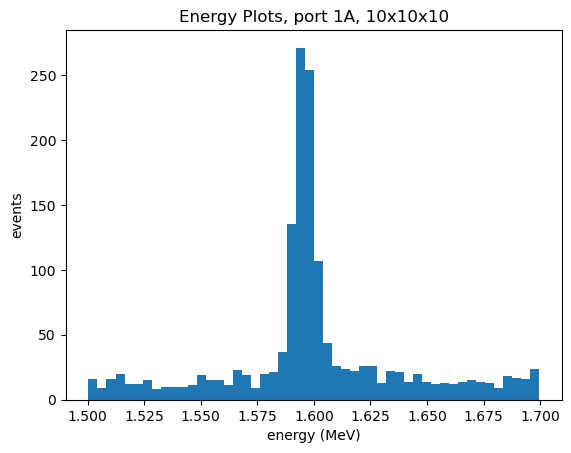

In [24]:
# just for visualising it
plot_hist(ecut_rel, binning = 50, title = 'Energy Plots, port 1A, 10x10x10')


In [25]:
# checking out some of the stranger tracks
display(low_e_cut_tracks[low_e_cut_tracks['numb_of_tracks'] == 2].head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,5080002,0,1.796149,136.325163,128,11033,2,-98.325,361.675,587.473511,...,613.110772,-6.622819,382.940215,589.840154,0.162713,0.073897,0.000000,9.750000,9.571429,9.902647
3,5080002,1,0.309468,112.683992,31,1829,2,52.675,348.675,498.257599,...,502.310940,54.698632,349.802676,526.248103,0.162199,0.021946,0.000000,9.750000,9.571429,9.902647
11,5080008,0,0.342280,16.484468,8,2861,2,214.675,211.675,251.550385,...,256.663612,227.209801,223.260120,266.541811,0.312121,0.312061,0.312061,9.166667,9.684211,9.691542
12,5080008,1,0.115869,13.700727,4,1023,2,241.675,346.675,439.461395,...,442.883644,245.679293,360.221708,446.314955,0.115869,0.115869,0.115869,9.166667,9.684211,9.691542
14,5080010,0,1.271544,73.387241,66,10049,2,-88.325,56.675,1118.789551,...,1135.595039,-51.756468,61.706668,1157.252430,0.526127,0.083108,0.000000,9.222222,9.942857,9.929548
15,5080010,1,0.142156,9.222222,2,1120,2,-84.325,355.675,578.050293,...,583.134599,-72.652758,360.711353,582.166985,0.142156,0.142156,0.142156,9.222222,9.942857,9.929548
32,5080020,0,1.890791,148.078438,142,11496,2,253.675,149.675,367.020935,...,382.736642,304.386566,261.943204,466.688660,0.189638,0.115920,0.000000,9.272727,9.842105,9.938828
33,5080020,1,0.207402,53.247930,21,1225,2,314.675,287.675,510.819214,...,510.819214,345.080070,330.328973,532.127471,0.065631,0.058258,0.000000,9.272727,9.842105,9.938828
41,5080034,0,2.355780,526.211104,224,12546,2,72.675,-40.325,331.339752,...,338.104605,207.523514,208.438640,506.390098,0.764477,0.111104,0.000000,9.857143,10.000000,9.827943
42,5080034,1,0.125304,14.041484,4,423,2,92.675,234.675,375.396118,...,379.195662,103.490109,240.859997,380.372550,0.125304,0.125304,0.125304,9.857143,10.000000,9.827943


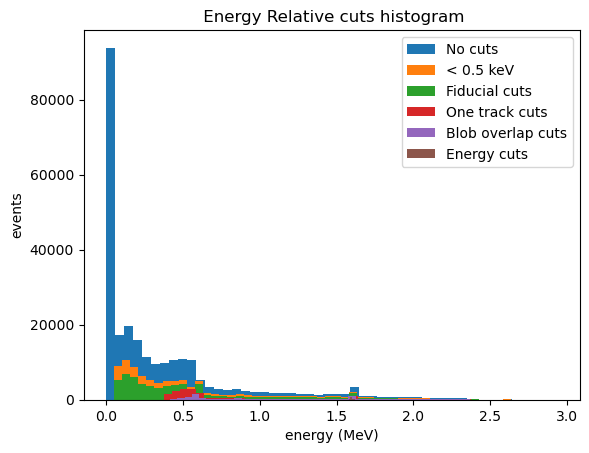

In [26]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50)
plot_hist(fiducial_rel, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

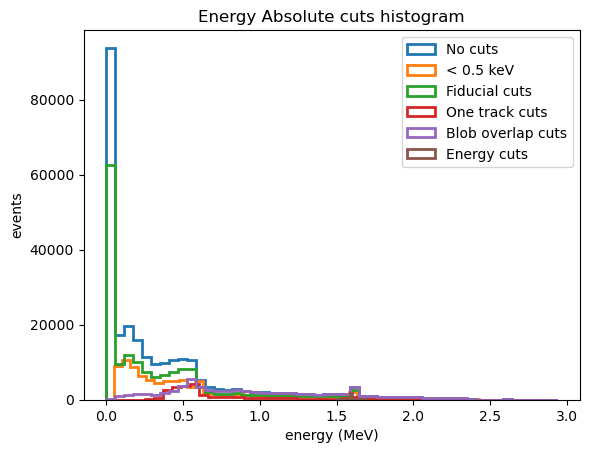

In [27]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50, fill = False)
plot_hist(fiducial_abs, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

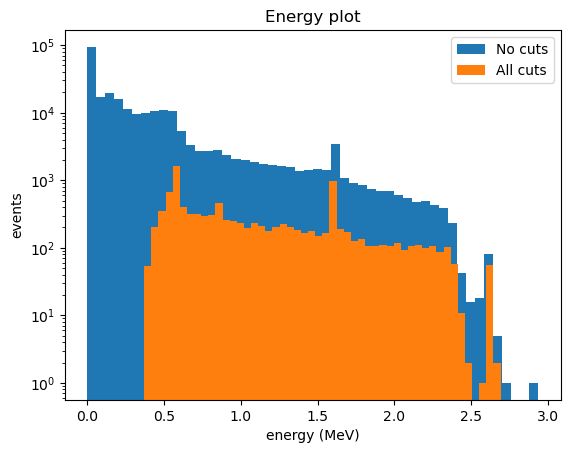

In [28]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

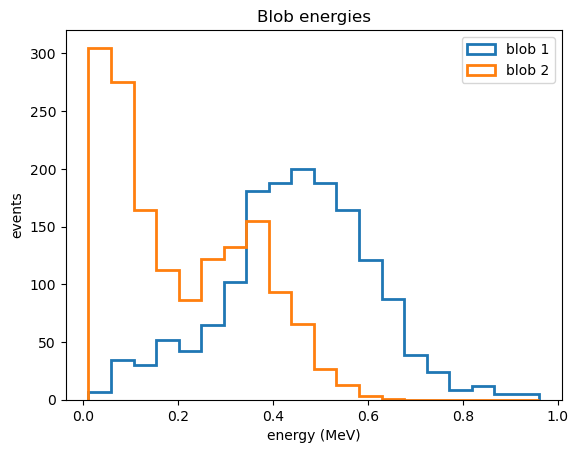

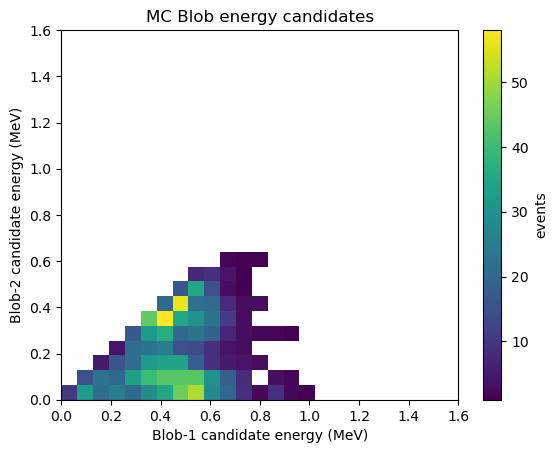

In [29]:
# plot blob energies

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

# Collecting all e+e- events 

In [30]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events.head(20))

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

print("Isaura events with no positrons")
display(ecut_no_positron_df.head(20))

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

print("Isaura events with positrons:")
display(ecut_positron_df.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_rel),len(ecut_positron_df), len(ecut_no_positron_df), len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel)))
print()

# make range full range of blob1 and blob2...
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

#...so that we can produce the min and max blob energy
minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)


True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
393,5080380,0,1.524555,192.344174,105,10753,1,8.675,-246.325,88.786362,...,95.391985,90.288190,-141.125375,211.595246,0.350357,0.040686,0.0,9.666667,9.666667,9.603581
803,1740082,0,1.621295,232.570108,143,11521,1,-9.325,-335.325,191.680923,...,255.239925,67.675000,-163.325000,249.403687,0.457842,0.014532,0.0,9.700000,9.761905,9.968830
1381,3580030,0,1.683973,309.345456,184,11844,1,67.675,-40.325,140.271973,...,144.278574,181.193226,66.589419,266.832110,0.551802,0.051860,0.0,9.916667,9.416667,9.934486
2412,1140492,0,1.669786,222.645782,133,12658,1,57.675,127.675,440.489655,...,466.288020,175.697472,260.613206,485.652361,0.693609,0.086716,0.0,9.461538,9.866667,8.913208
2420,1140496,0,1.693440,246.575151,107,12740,1,-119.325,289.675,206.399658,...,236.578626,85.710053,370.584769,256.849049,0.704509,0.137647,0.0,9.666667,9.636364,9.256134
2502,1140578,0,1.527769,167.415720,139,12203,1,167.675,170.675,372.266418,...,379.981042,195.770952,258.570397,439.204290,0.597407,0.167646,0.0,9.125000,9.384615,9.755881
2551,1140630,0,1.581736,250.181210,152,12960,1,242.675,-28.325,584.348755,...,673.604405,329.007723,169.294916,592.310692,0.368876,0.093841,0.0,9.400000,9.708333,9.440906
3654,80494,0,1.582480,251.467251,144,11584,1,-171.325,191.675,361.742035,...,415.074954,13.501280,300.826014,399.352786,0.534098,0.060950,0.0,9.843750,9.727273,9.703777
4338,20636,0,1.571437,219.526846,159,11672,1,-9.325,-125.325,337.597870,...,345.600961,78.387606,-6.285645,469.961256,0.495933,0.045397,0.0,9.300000,9.466667,9.520885
4650,3900320,0,1.584964,201.340848,127,9732,1,225.675,287.675,670.439270,...,799.550616,259.457059,360.652292,674.923034,0.546570,0.064789,0.0,9.142857,9.769231,9.612488


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
184,5080188,0,1.596243,137.456298,113,11993,1,156.675,107.675,734.490601,...,789.447427,249.494267,184.766019,738.319437,0.511776,0.245868,0.0,10.000000,9.333333,9.592146
518,5080496,0,1.594183,154.743531,127,12870,1,147.675,-166.325,322.920868,...,348.181738,150.682122,-134.107884,329.234220,0.444847,0.443488,0.0,9.533333,9.200000,8.737142
606,5080582,0,1.595847,134.427703,165,12424,1,293.675,-43.325,683.036133,...,726.958593,344.200068,58.357780,714.376938,0.327431,0.169420,0.0,9.272727,9.615385,8.566711
674,5080676,0,1.594673,123.527479,117,12643,1,185.675,150.675,453.089264,...,466.743201,273.441110,157.500124,496.954274,0.612307,0.345949,0.0,9.416667,10.000000,9.292014
741,1740022,0,1.595029,246.160982,147,12240,1,186.675,-40.325,405.846893,...,498.364705,201.867704,58.954131,414.055713,0.492123,0.414989,0.0,10.000000,9.333333,9.967749
1269,1740572,0,1.610053,145.416054,150,12892,1,-101.325,-456.325,436.304749,...,522.938656,-90.355666,-372.274817,527.177016,0.448995,0.172687,0.0,9.000000,9.384615,9.442682
1512,3580184,0,1.596952,210.176919,136,12720,1,87.675,286.675,153.902756,...,214.041428,218.983909,291.827323,188.099396,0.496821,0.448385,0.0,9.857143,9.714286,9.726704
1673,3580384,0,1.608184,156.671782,138,12844,1,-132.325,83.675,967.594543,...,980.742616,-38.293017,199.577009,1025.428229,0.343598,0.258966,0.0,9.900000,9.437500,9.095669
1836,3580568,0,1.587940,72.108443,78,11981,1,-284.325,-63.325,227.352615,...,255.964403,-279.837385,-2.068621,245.422964,0.588401,0.306167,0.0,9.100000,9.857143,8.167691
2071,1140132,0,1.591198,118.954270,114,11963,1,85.675,-225.325,101.465935,...,108.966936,128.848754,-218.701500,170.109111,0.584663,0.471433,0.0,9.500000,9.500000,9.661274


Isaura events total: 1554
Positron Events: 926
Non-positron events: 628
Does this add up? True



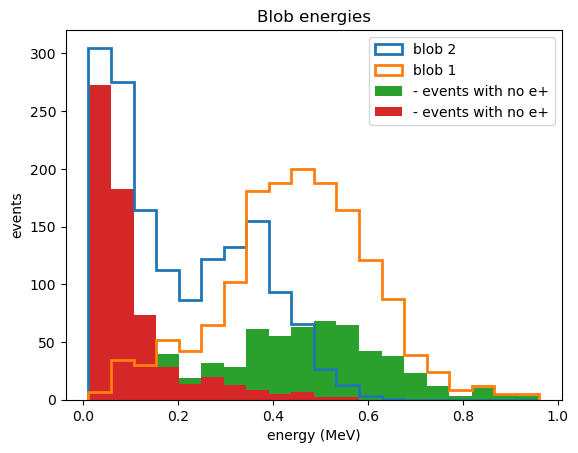

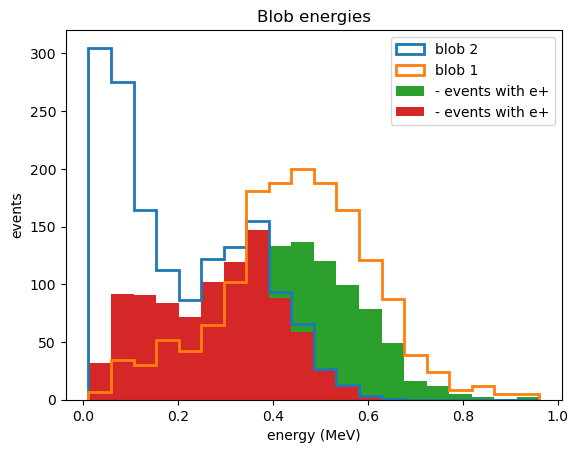

In [31]:

these_bins = 20
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

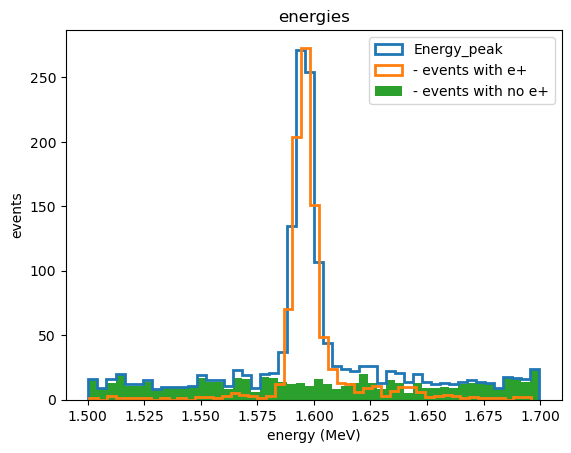

In [32]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = '- events with e+', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

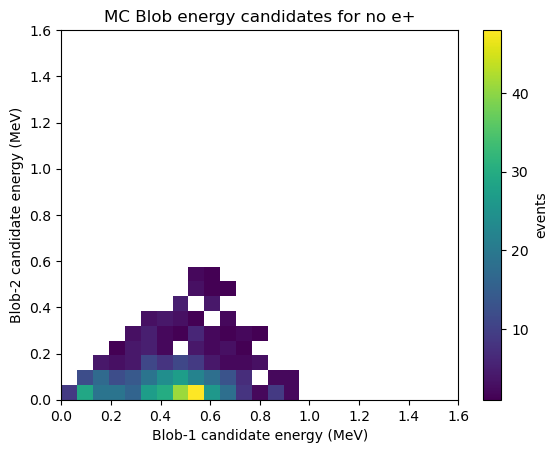

In [36]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

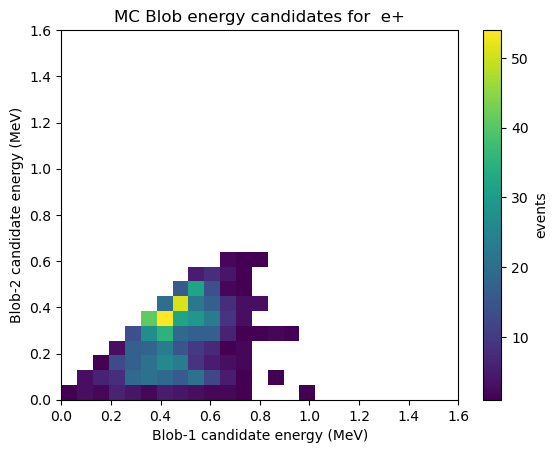

In [37]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_positron_df['eblob1'], ecut_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for  e+")
plt.show()

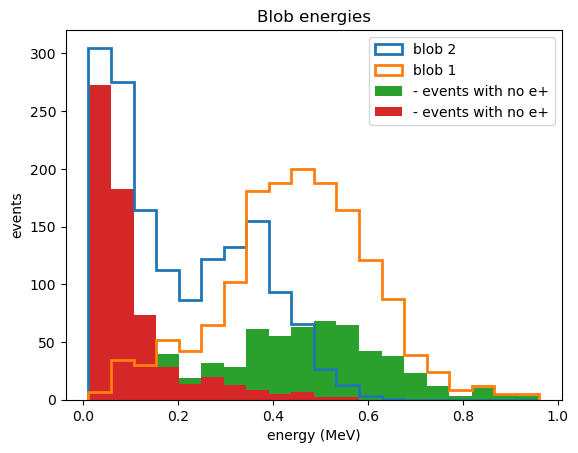

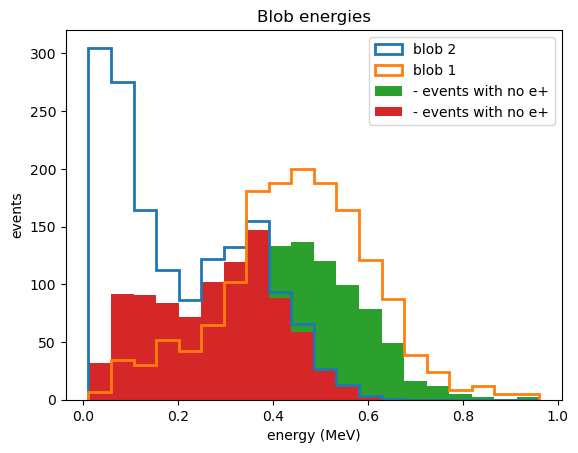

In [38]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)
blob_positron_plot(ecut_rel, ecut_positron_df)

# Now to readadapt the code to give true FOM from sig and background while adjusting the cut location.

In [39]:


def true_fom_calc(p_data, no_p_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    # create deep copies for safety
    pos_data = p_data.copy(deep = True)
    no_pos_data = no_p_data.copy(deep = True)

    if (verbose == True):
        blob_positron_plot(pos_data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    ns0 = len(pos_data.index)
    nb0 = len(no_pos_data.index)
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        pos_data = pos_data[(pos_data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]


        # apply fit to the new data 
        if (verbose == True):
            print("Signal events: {}\nBackground events: {}\n FOM: {}".format())
        
        # collect number of signal events vs number of backgrounds, which you know 
        ns = len(pos_data.index)
        nb = len(no_pos_data.index)

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(pos_data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom

In [40]:
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom = true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

/tmp/ipykernel_37947/496507008.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


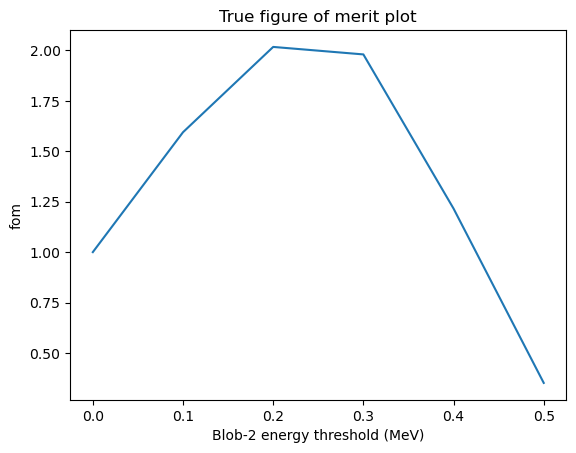

In [41]:
# plot fom
plt.plot(cut_list, fom)
plt.title("True figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

### Lets try a more aggressive cut around the peak to reduce FOM?

In [42]:
ecut_slim = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625)


In [43]:
# create e+ dataframe only
positron_df_slim = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events_slim = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events_slim.head(20))

# collect events
pos_events_slim = np.unique(positron_events_slim['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events_slim)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df_slim = ecut_slim[~ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with no positrons")
display(ecut_no_positron_df_slim.head(20))

# events with positrons only in here!
ecut_positron_df_slim = ecut_slim[ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with positrons:")
display(ecut_positron_df_slim.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_slim),len(ecut_positron_df_slim), len(ecut_no_positron_df_slim), len(ecut_positron_df_slim) + len(ecut_no_positron_df_slim) == len(ecut_slim)))
print()



True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
803,1740082,0,1.621295,232.570108,143,11521,1,-9.325,-335.325,191.680923,...,255.239925,67.675000,-163.325000,249.403687,0.457842,0.014532,0.0,9.700000,9.761905,9.968830
2551,1140630,0,1.581736,250.181210,152,12960,1,242.675,-28.325,584.348755,...,673.604405,329.007723,169.294916,592.310692,0.368876,0.093841,0.0,9.400000,9.708333,9.440906
3654,80494,0,1.582480,251.467251,144,11584,1,-171.325,191.675,361.742035,...,415.074954,13.501280,300.826014,399.352786,0.534098,0.060950,0.0,9.843750,9.727273,9.703777
4650,3900320,0,1.584964,201.340848,127,9732,1,225.675,287.675,670.439270,...,799.550616,259.457059,360.652292,674.923034,0.546570,0.064789,0.0,9.142857,9.769231,9.612488
5056,1560084,0,1.607787,269.520926,150,12379,1,-132.325,158.675,31.159515,...,33.186187,-73.451906,319.656001,68.769089,0.344945,0.101011,0.0,9.333333,9.500000,9.415369
5442,1560468,0,1.586793,70.394814,67,12577,1,181.675,28.675,1021.142090,...,1034.360993,222.546347,93.383009,1040.291249,0.473275,0.153283,0.0,9.687500,9.882353,9.919745
6195,3840588,0,1.597800,256.970444,149,11443,1,201.675,219.675,525.563904,...,531.114852,247.758126,360.184326,550.315550,0.734237,0.060953,0.0,10.000000,9.588235,9.335223
6568,2720320,0,1.576866,101.389410,127,12372,1,239.675,-4.325,534.972046,...,602.923743,271.159979,8.728768,539.063263,0.465571,0.122953,0.0,9.444444,9.375000,9.446136
6579,2720332,0,1.602028,220.425062,131,10765,1,12.675,96.675,358.611816,...,402.429359,194.679453,131.992353,375.508508,0.392550,0.019380,0.0,9.772727,9.857143,9.539848
7816,2020254,0,1.594091,192.979055,184,11619,1,-2.325,37.675,337.599640,...,346.421032,84.274095,86.866490,455.194151,0.347903,0.130267,0.0,9.272727,9.818182,9.929610


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
184,5080188,0,1.596243,137.456298,113,11993,1,156.675,107.675,734.490601,...,789.447427,249.494267,184.766019,738.319437,0.511776,0.245868,0.0,10.000000,9.333333,9.592146
518,5080496,0,1.594183,154.743531,127,12870,1,147.675,-166.325,322.920868,...,348.181738,150.682122,-134.107884,329.234220,0.444847,0.443488,0.0,9.533333,9.200000,8.737142
606,5080582,0,1.595847,134.427703,165,12424,1,293.675,-43.325,683.036133,...,726.958593,344.200068,58.357780,714.376938,0.327431,0.169420,0.0,9.272727,9.615385,8.566711
674,5080676,0,1.594673,123.527479,117,12643,1,185.675,150.675,453.089264,...,466.743201,273.441110,157.500124,496.954274,0.612307,0.345949,0.0,9.416667,10.000000,9.292014
741,1740022,0,1.595029,246.160982,147,12240,1,186.675,-40.325,405.846893,...,498.364705,201.867704,58.954131,414.055713,0.492123,0.414989,0.0,10.000000,9.333333,9.967749
1269,1740572,0,1.610053,145.416054,150,12892,1,-101.325,-456.325,436.304749,...,522.938656,-90.355666,-372.274817,527.177016,0.448995,0.172687,0.0,9.000000,9.384615,9.442682
1512,3580184,0,1.596952,210.176919,136,12720,1,87.675,286.675,153.902756,...,214.041428,218.983909,291.827323,188.099396,0.496821,0.448385,0.0,9.857143,9.714286,9.726704
1673,3580384,0,1.608184,156.671782,138,12844,1,-132.325,83.675,967.594543,...,980.742616,-38.293017,199.577009,1025.428229,0.343598,0.258966,0.0,9.900000,9.437500,9.095669
1836,3580568,0,1.587940,72.108443,78,11981,1,-284.325,-63.325,227.352615,...,255.964403,-279.837385,-2.068621,245.422964,0.588401,0.306167,0.0,9.100000,9.857143,8.167691
2071,1140132,0,1.591198,118.954270,114,11963,1,85.675,-225.325,101.465935,...,108.966936,128.848754,-218.701500,170.109111,0.584663,0.471433,0.0,9.500000,9.500000,9.661274


Isaura events total: 995
Positron Events: 826
Non-positron events: 169
Does this add up? True



In [44]:
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom_slim = true_fom_calc(ecut_positron_df_slim, ecut_no_positron_df_slim, cut_list)

/tmp/ipykernel_37947/496507008.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


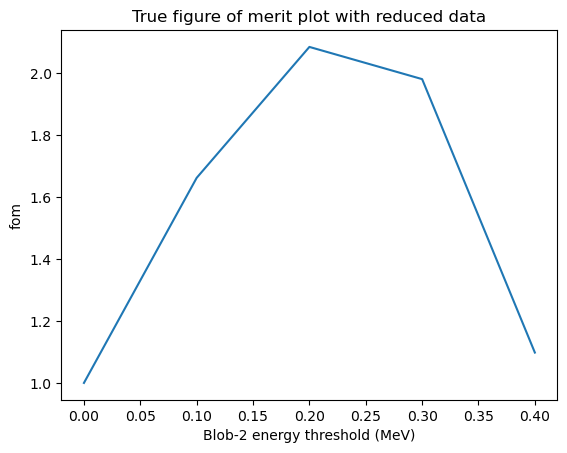

In [45]:
# plot fom
plt.plot(cut_list, fom_slim)
plt.title("True figure of merit plot with reduced data")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

Reducing the range makes it worse. Should have expected this in all honesty...

### Applying fitting

In [46]:
# lets try this ourselves

def bck_func(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)



def skewnorm_func(x, a, mu, sigma):
    return skewnorm.pdf(x, a, loc = mu, scale = sigma)



def error_func(x, mu, sigma):
    pas = (x - mu)/(np.sqrt(2)*sigma)
    return special.erfc(pas)



def sig_func(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)



def sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau):

    return bck_func(x, nb, tau) + sig_func(x, ns, a, mu, sigma, C1, C2)


# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)


def gauss_norm(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)


    return (a*np.exp(-numer/denom))/ norm

def gauss_bck_norm(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)

    return (a*np.exp(-numer/denom) / norm) + C    


def bck(x, C):
    return np.full_like(x, C)

def gauss_bck(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)


    return a*np.exp(-numer/denom) + C

# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0

 
# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000, lgnd = 'Fit', popt_text = True):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = lgnd, color = colour)
    
    # create locations to put the text relative to the scale of the figure
    percentage_hor = 0.01
    percentage_vert = 0.95
    x_loc = np.min(x) + (np.max(x) - np.min(x))*percentage_hor
    y_loc = np.min(y) + (np.max(y) - np.min(y))*percentage_vert
    # reasonable gap for separation, based on scale
    gap = (np.max(y) - np.min(y)) * 0.05

    if (popt_text == False):
        for i in range(len(popt)):

            plt.text(x_loc, y_loc - gap*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)), verticalalignment='top', horizontalalignment='left')

    if (output == True):
        plt.show()
    else:
        return


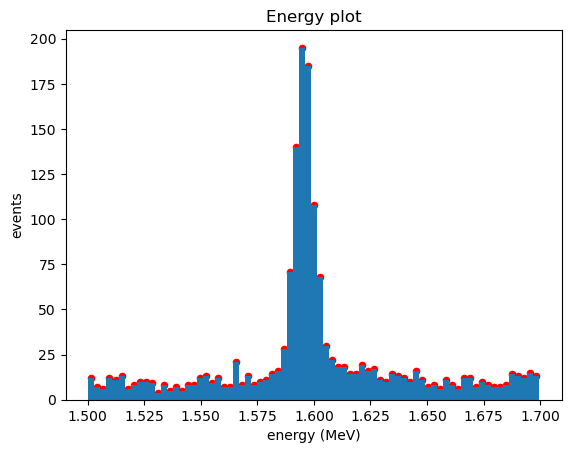

In [47]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [48]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)

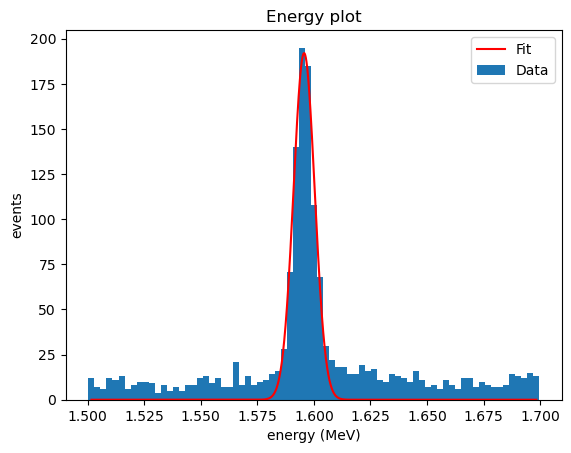

[1.92013024e+02 1.59568079e+00 4.67124400e-03]
(2.2482943759557408, 1.6923592426558833e-08)
        Fitting output      
a: 192.0130 ± 7.7278
mu: 1.5957 ± 0.0002
sigma: 0.0047 ± 0.0002


In [49]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()

print(popt)
print(quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2])))

nothing = print_parameters(popt, pcov, gauss_labels)
del nothing

#### Try fitting it all now

In [50]:
# fit full thing to this

# ns -> take as fraction of peak. Example: peak at 1000 events, ns at 1000*8

# p0 is the initial guesses
p1 = ([5, -2.8, 1.6, 0.006, 0.05, 0.0001, 10, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 500000)

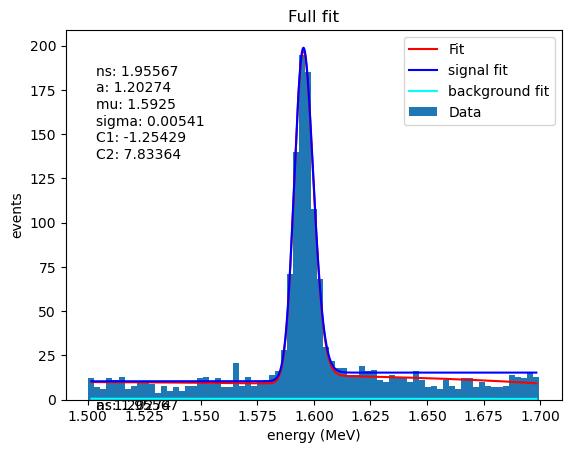

        Fitting output      
ns: 1.9557 ± 0.0340
a: 1.2027 ± 0.2495
mu: 1.5925 ± 0.0004
sigma: 0.0054 ± 0.0003
C1: -1.2543 ± 0.7187
C2: 7.8336 ± 2.9133
nb: -0.0000 ± 0.0000
tau: -0.0749 ± 0.1204


0

In [51]:
plot_fit(sig_bck_func, centres, popt, big_labels)
plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue', popt_text = False)
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan', popt_text = False)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)



#### Cut @ 0.2 MeV for blob 2 and see how the fit looks

In [52]:
ecut_200keV = ecut_rel[(ecut_rel['eblob2'] > 0.2)]


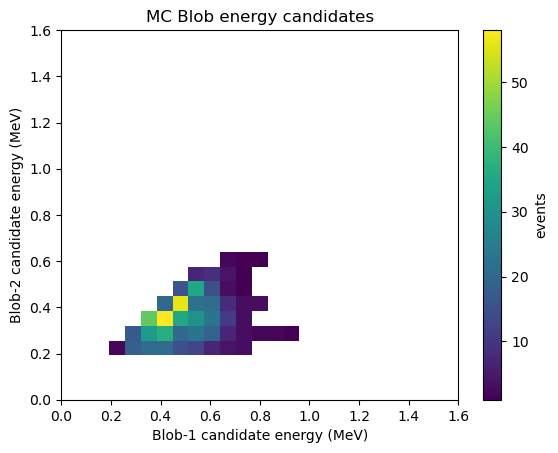

In [53]:
plt.hist2d(ecut_200keV['eblob1'], ecut_200keV['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

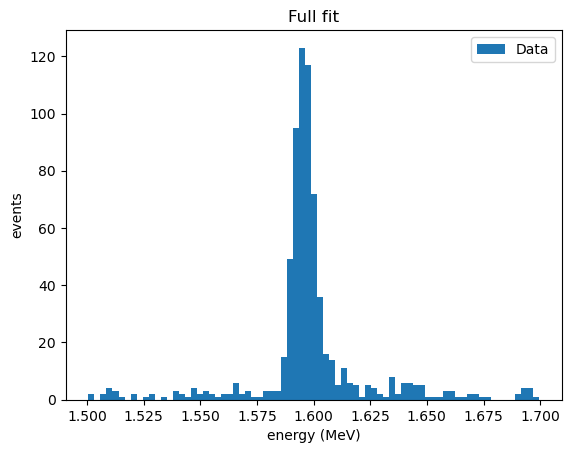

In [54]:
plot_hist(ecut_200keV, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()

### trying gauss with basic background, and then a FOM for this up to 0.2 MeV

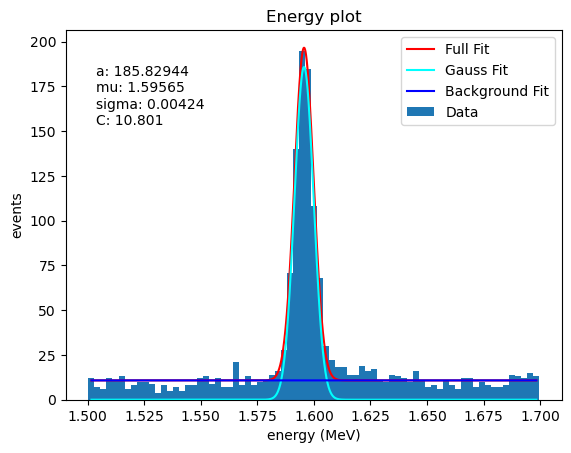

        Fitting output      
a: 185.8294 ± 3.0900
mu: 1.5957 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 10.8010 ± 0.5169
ns = 743.924870144747
nb = 813.1049848475602
total = 1557.0298549923073


In [55]:
# first, lets try fitting it
p0 = [1, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

popt, pcov = curve_fit(gauss_bck, centres, hist, p0, maxfev = 5000000)

plot_fit(gauss_bck, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2]))/bin_width
nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))
print("total = {}".format(ns0[0]+nb0[0]))

In [56]:
len(ecut_rel)

1554

### So we can see from above that this works as expected (get approximately the same number of events as we wish)

In [57]:
# integrate over these functions now

print(list(popt[:-1]))
ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))
nb0 = quad(bck, emin, emax, args = popt[-1])

print(ns0)
print(nb0)

[185.82943893145094, 1.5956538196976364, 0.004242990265462003]
(1.9764074633278204, 1.7938810748484302e-08)
(2.1602003441679396, 2.398304159898434e-14)


### Re-using old code to apply FOM cuts here

In [60]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    plt.clf()
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = [1, 1.58, 0.006, 5]
    gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

    # fit function
    popt, pcov = curve_fit(gauss_bck, centres, hist, p1, maxfev = 5000000)

    if (verbose == True):
        plot_fit(gauss_bck, centres, popt, gauss_bck_labels)
        plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = False)
        plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
        
        plot_hist(data, binning = bins, output = False, data = True, label='Data')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, gauss_bck_labels)

    # centres passed through to ensure we get the correct even numbers
    return (popt, pcov, gauss_bck_labels, centres)
        



def fom_calc(data, cut_list, no_pos_data = pd.DataFrame({'A' : []}), binning = 75, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    no_pos_data related to data with no positrons in it (background).
    Useful to visualise for 
    '''

    if ((verbose == True) and not (no_pos_data.empty)):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, bins = binning, verbose = True)

    popt = output[0]
    pcov = output[1]
    gauss_bck_labels = output[2]
    centres = output[3]

    # take bin widths to calculate number of events
    bin_width = centres[1] - centres[0]

    # signal is integration of function over the space
    ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
    nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width

    if (verbose == True):
        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(data.index)))


    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        print("")
        print("")
        print("")
        
        print("==========================")
        print("        CUT {} MeV       ".format(cut_list[i]))
        print("==========================")
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        if not (no_pos_data.empty):
            no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, bins = binning, verbose = True)
        else:
            output = default_fit(data, bins = binning, verbose = False)
        
        # collect values
        popt = output[0]
        pcov = output[1]
        gauss_bck_labels = output[2]
        centres = output[3]

        # take bin widths to calculate number of events
        bin_width = centres[1] - centres[0]

        # collect ns and nb
        ns = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
        nb = quad(bck, emin, emax, args = popt[-1])/bin_width

        if (verbose == True):
            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(data.index)))
        # produce fom value (DISCREETLY NOW AS IT ISNT WORKING)
        e_check     = ns[0]/ns0[0]
        b_check     = nb[0]/nb0[0]
        fom_check   = e_check/np.sqrt(b_check)
        

        print('\ne_i: {}\nb_i: {}\nfom: {}'.format(e_check, b_check, fom_check))

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        if ((verbose == True) and not (no_pos_data.empty)):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






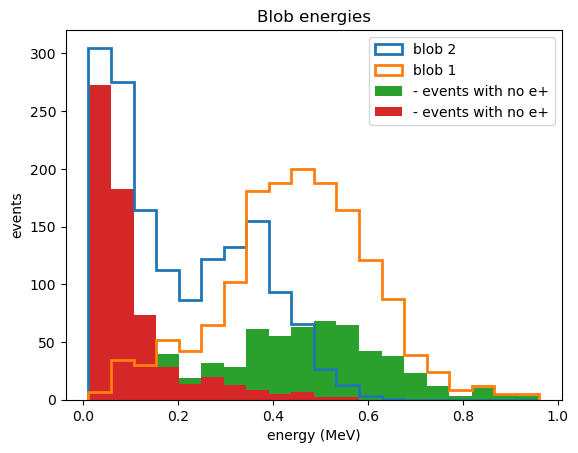

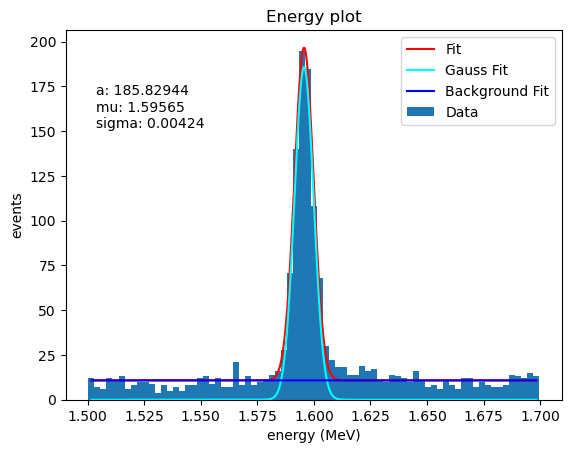

        Fitting output      
a: 185.8294 ± 3.0900
mu: 1.5957 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 10.8010 ± 0.5169
ns0      = 743.924870144747
nb0      = 813.1049848475602
total    = 1557
Event no = 1554



        CUT 0 MeV       


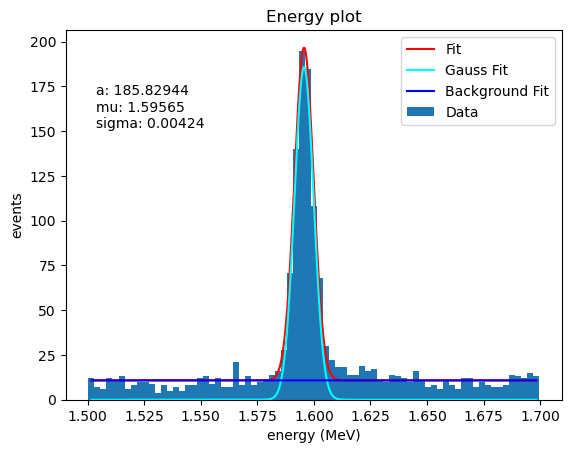

        Fitting output      
a: 185.8294 ± 3.0900
mu: 1.5957 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 10.8010 ± 0.5169
ns - 743.924870144747
nb - 813.1049848475602
total = 1557
Event no = 1554

e_i: 1.0
b_i: 1.0
fom: 1.0


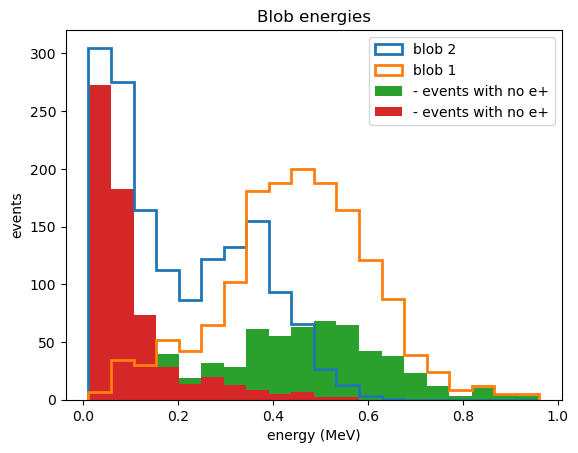




        CUT 0.05 MeV       


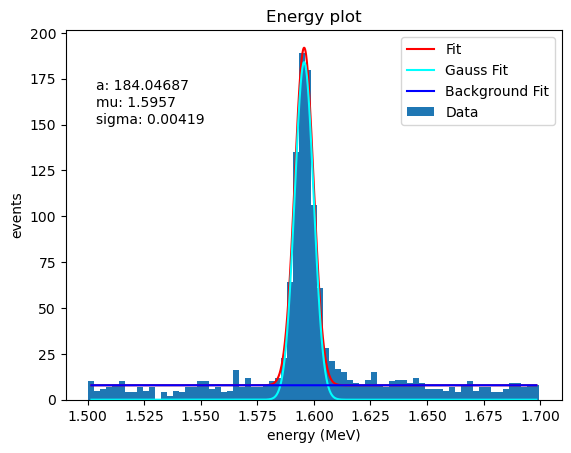

        Fitting output      
a: 184.0469 ± 2.7667
mu: 1.5957 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 7.8885 ± 0.4595
ns - 727.3640936795572
nb - 593.8487529116323
total = 1321
Event no = 1319

e_i: 0.9777386438741219
b_i: 0.7303469588530026
fom: 1.144084673896766


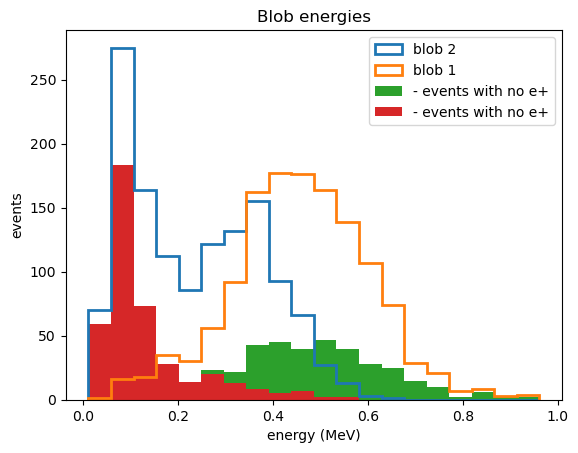




        CUT 0.1 MeV       


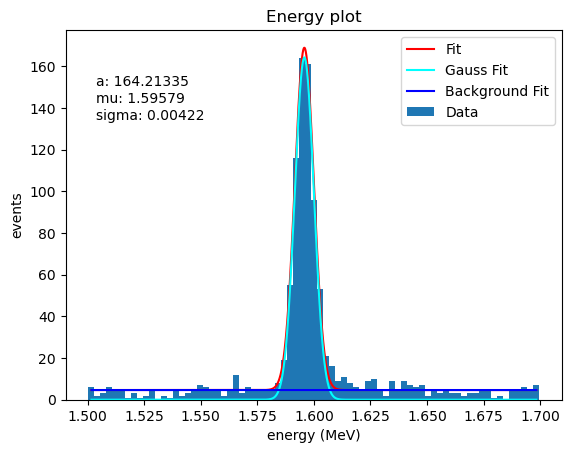

        Fitting output      
a: 164.2133 ± 2.1904
mu: 1.5958 ± 0.0001
sigma: 0.0042 ± 0.0001
C: 4.6473 ± 0.3652
ns - 653.4518358969373
nb - 349.8518105819329
total = 1003
Event no = 1002

e_i: 0.8783841784584965
b_i: 0.43026646878511343
fom: 1.3391084591306763


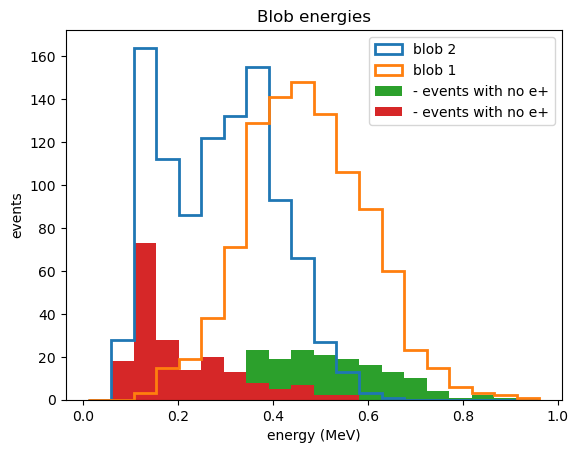




        CUT 0.15 MeV       


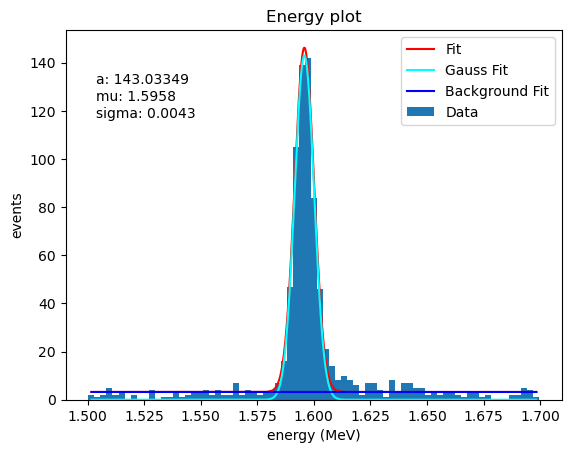

        Fitting output      
a: 143.0335 ± 2.0710
mu: 1.5958 ± 0.0001
sigma: 0.0043 ± 0.0001
C: 3.2200 ± 0.3491
ns - 580.4986549367995
nb - 242.4118828386737
total = 823
Event no = 822

e_i: 0.7803189249794145
b_i: 0.2981310991275263
fom: 1.4291193493395806


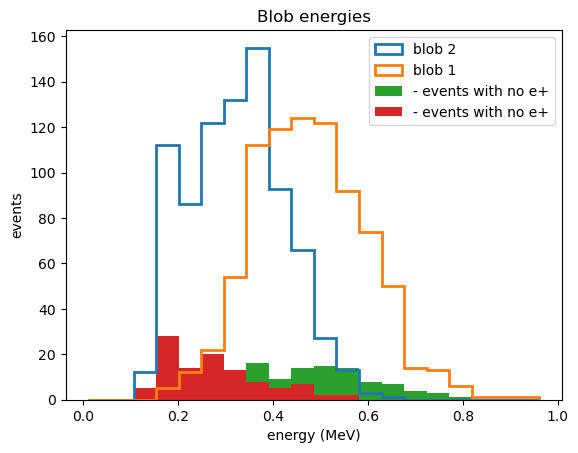




        CUT 0.2 MeV       


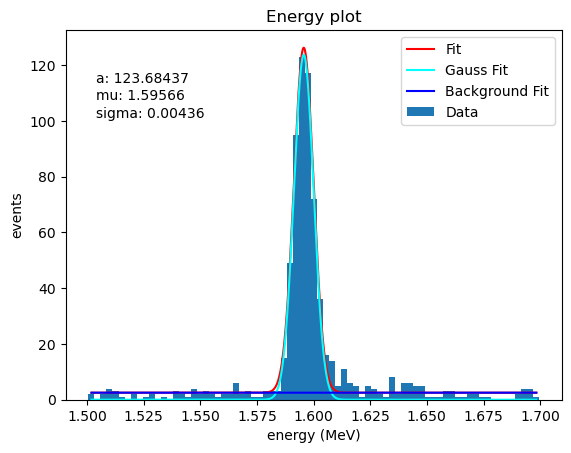

        Fitting output      
a: 123.6844 ± 1.7999
mu: 1.5957 ± 0.0001
sigma: 0.0044 ± 0.0001
C: 2.5196 ± 0.3061
ns - 510.0279510077811
nb - 189.9385120384225
total = 700
Event no = 699

e_i: 0.6855906711500905
b_i: 0.2335965411330394
fom: 1.4185076933507796


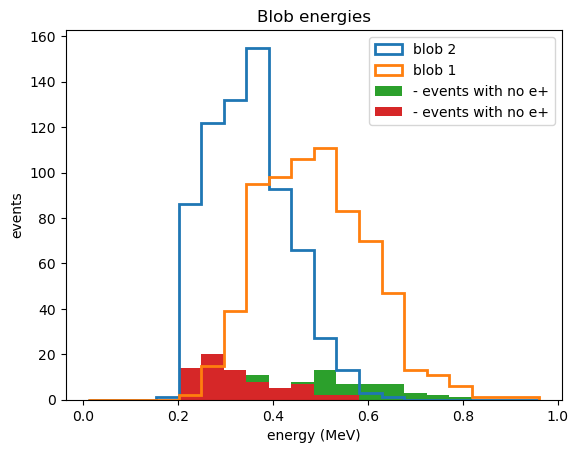




        CUT 0.25 MeV       


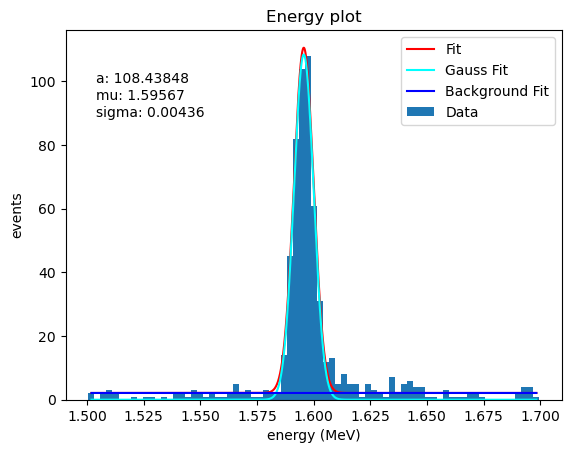

        Fitting output      
a: 108.4385 ± 1.7529
mu: 1.5957 ± 0.0001
sigma: 0.0044 ± 0.0001
C: 2.1210 ± 0.2980
ns - 446.92310080374824
nb - 159.89046865634333
total = 607
Event no = 606

e_i: 0.6007637581961596
b_i: 0.19664185023575936
fom: 1.3547705565704102


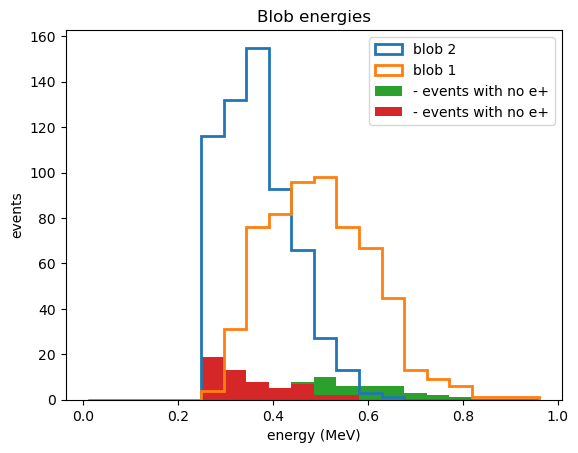




        CUT 0.3 MeV       


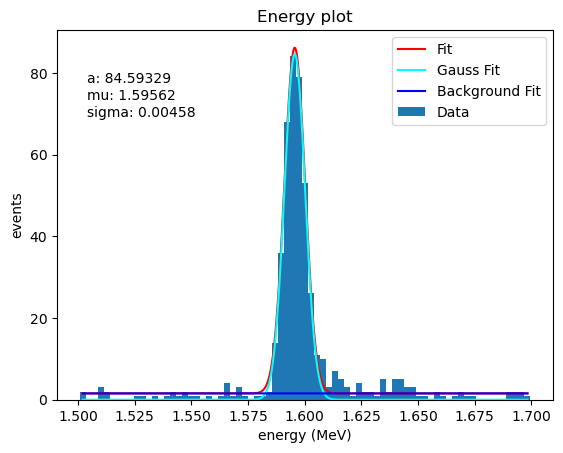

        Fitting output      
a: 84.5933 ± 1.2349
mu: 1.5956 ± 0.0001
sigma: 0.0046 ± 0.0001
C: 1.5451 ± 0.2158
ns - 366.1211753976702
nb - 116.47146530113268
total = 483
Event no = 482

e_i: 0.4921480516257417
b_i: 0.14324283760598097
fom: 1.3003471563067786


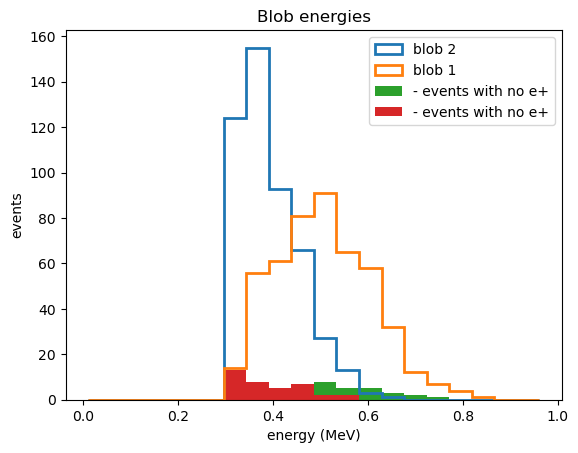




        CUT 0.35 MeV       


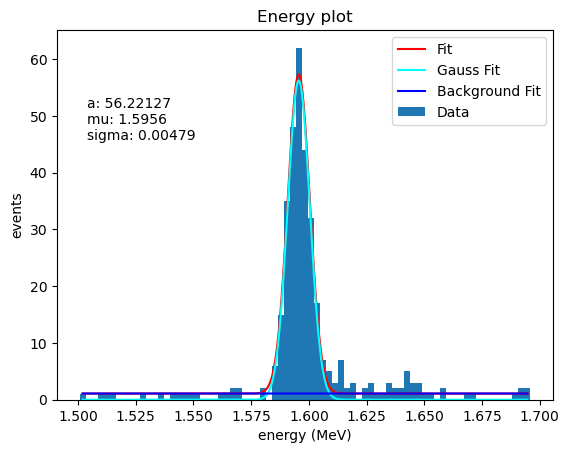

        Fitting output      
a: 56.2213 ± 1.1043
mu: 1.5956 ± 0.0001
sigma: 0.0048 ± 0.0001
C: 1.0903 ± 0.1999
ns - 259.22817040166177
nb - 83.72436058701865
total = 343
Event no = 341

e_i: 0.34846014806740255
b_i: 0.10296869672089783
fom: 1.0859266937359697


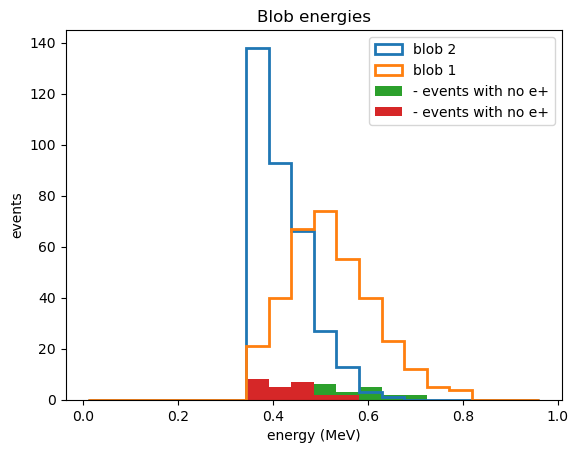




        CUT 0.4 MeV       


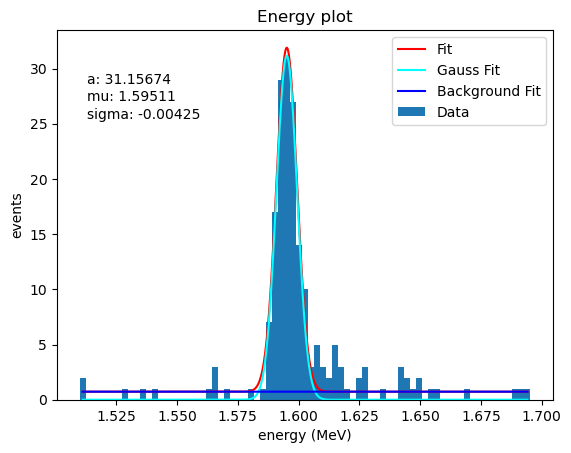

        Fitting output      
a: 31.1567 ± 0.8772
mu: 1.5951 ± 0.0001
sigma: -0.0043 ± 0.0001
C: 0.7286 ± 0.1529
ns - 134.35709723771924
nb - 58.948773941361424
total = 193
Event no = 189

e_i: 0.18060573403276206
b_i: 0.07249835512005016
fom: 0.6707604663082257


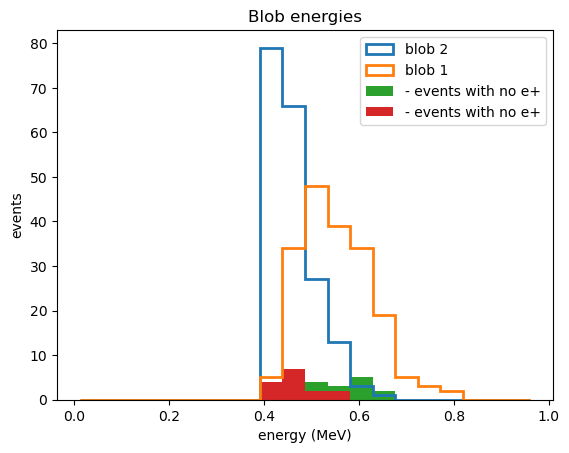

In [61]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
fom = fom_calc(ecut_rel, cut_list, no_pos_data = ecut_no_positron_df, verbose = True)

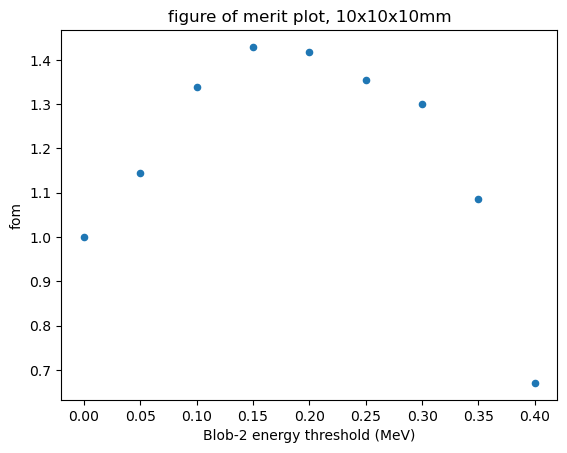

In [63]:
# plot fom
plt.scatter(cut_list, fom, s = 20)
plt.title("figure of merit plot, 10x10x10mm")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

#### trying smaller range of E values

In [319]:
print(len(slimmed_E.index))
# so there are only this number of events!

799


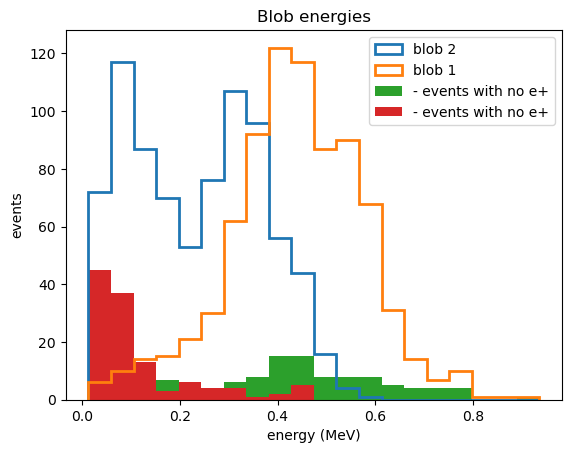

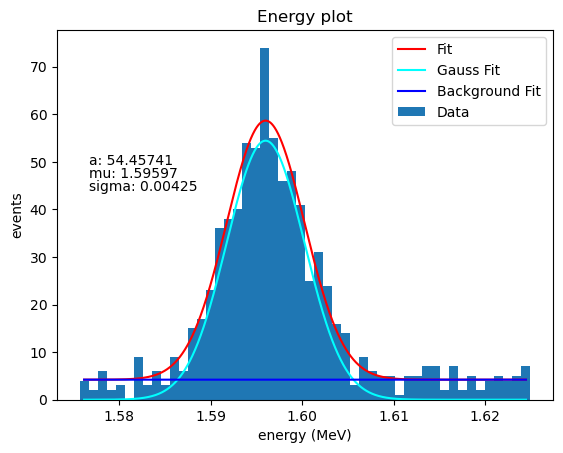

        Fitting output      
a: 54.4574 ± 1.7948
mu: 1.5960 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 4.2174 ± 0.7439
ns0 - 588.1329434452939
nb0 - 855.625394136632



        CUT 0 MeV       


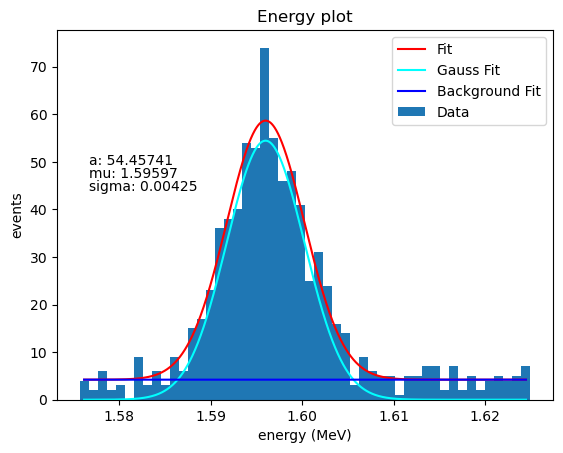

        Fitting output      
a: 54.4574 ± 1.7948
mu: 1.5960 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 4.2174 ± 0.7439
ns - 588.1329434452939
nb - 855.625394136632

e_i: 1.0
b_i: 1.0
fom: 1.0


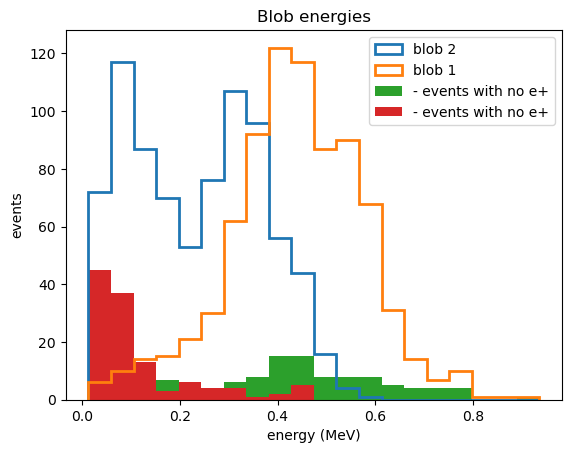




        CUT 0.05 MeV       


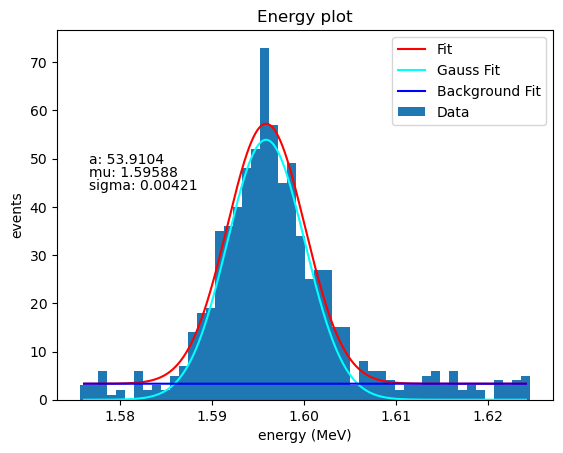

        Fitting output      
a: 53.9104 ± 1.8178
mu: 1.5959 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 3.3226 ± 0.7519
ns - 580.8726949951243
nb - 679.01220245749

e_i: 0.9876554297270973
b_i: 0.793585846224967
fom: 1.1086858351592073


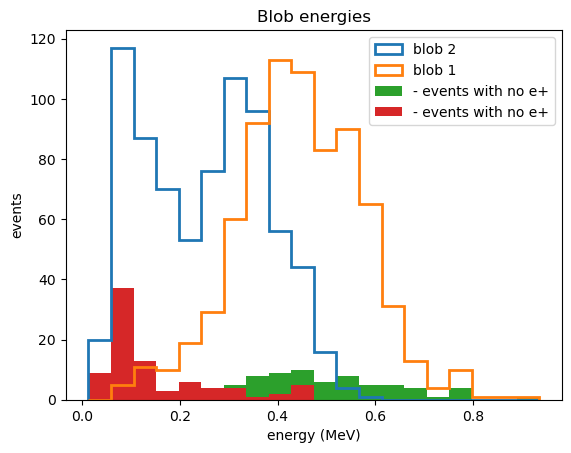




        CUT 0.1 MeV       


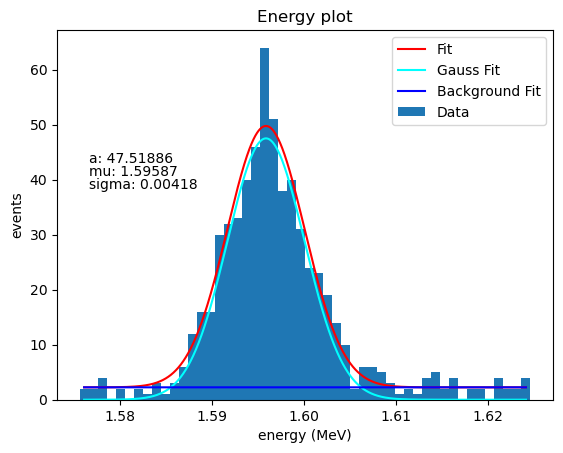

        Fitting output      
a: 47.5189 ± 1.5320
mu: 1.5959 ± 0.0001
sigma: 0.0042 ± 0.0002
C: 2.2541 ± 0.6309
ns - 509.29324888559387
nb - 460.66652123372046

e_i: 0.8659491949254609
b_i: 0.5383974393356518
fom: 1.180160079482056


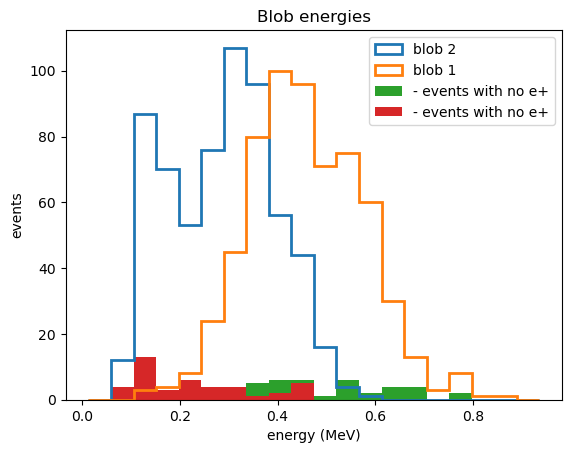




        CUT 0.15 MeV       


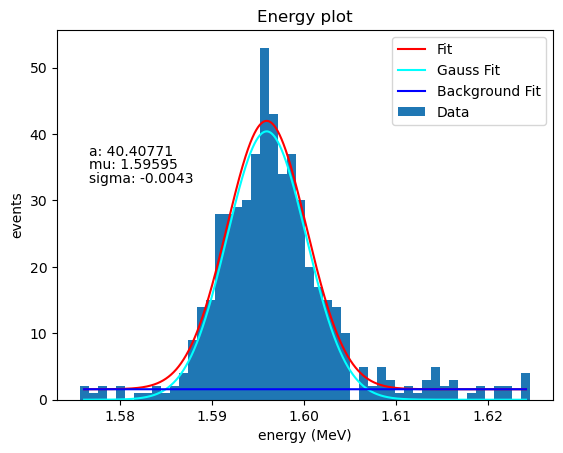

        Fitting output      
a: 40.4077 ± 1.3741
mu: 1.5959 ± 0.0002
sigma: -0.0043 ± 0.0002
C: 1.5777 ± 0.5792
ns - 445.11504334398245
nb - 322.4277467468916

e_i: 0.756827258708703
b_i: 0.3768328394136046
fom: 1.2328845049054253


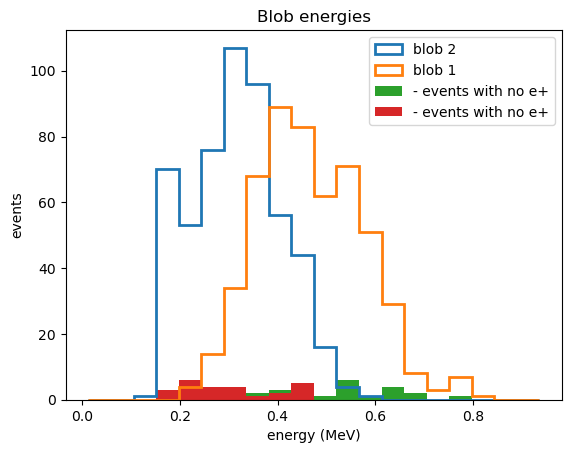




        CUT 0.2 MeV       


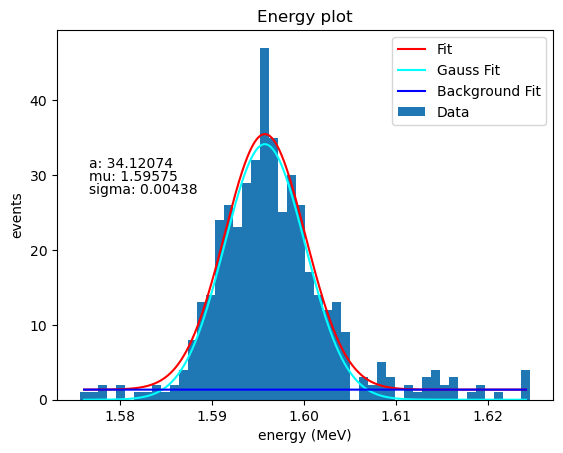

        Fitting output      
a: 34.1207 ± 1.3192
mu: 1.5957 ± 0.0002
sigma: 0.0044 ± 0.0002
C: 1.3474 ± 0.5646
ns - 382.6292842446868
nb - 275.36694063433157

e_i: 0.6505829821455625
b_i: 0.32183119215645806
fom: 1.1468025022641548


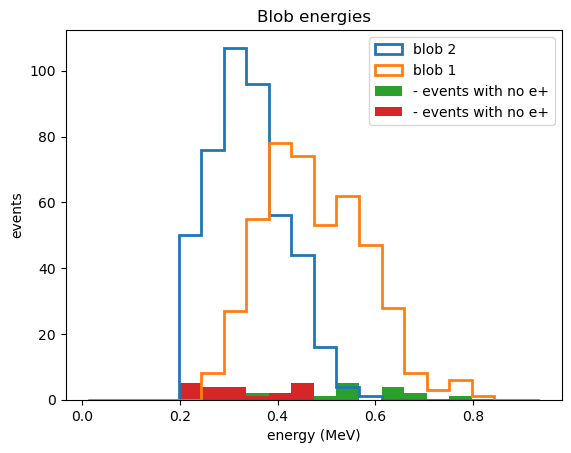

In [318]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2]

# slim the data
slimmed_E = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625, verbose = False)
slimmed_nopos = energy_cuts(ecut_no_positron_df, lower_e = 1.575, upper_e = 1.625, verbose = False)


fom_slimmed = fom_calc(slimmed_E, cut_list, no_pos_data = slimmed_nopos, verbose = True, binning = 50)

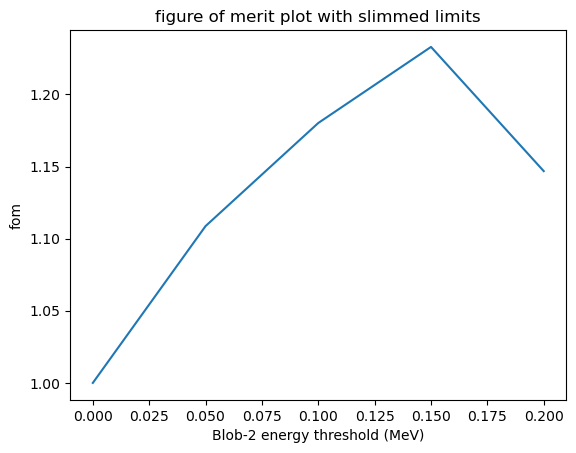

In [308]:
# plot fom
plt.plot(cut_list, fom_slimmed)
plt.title("figure of merit plot with slimmed limits")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

#### trying normalised now

[150, 1.58, 0.006, 5]


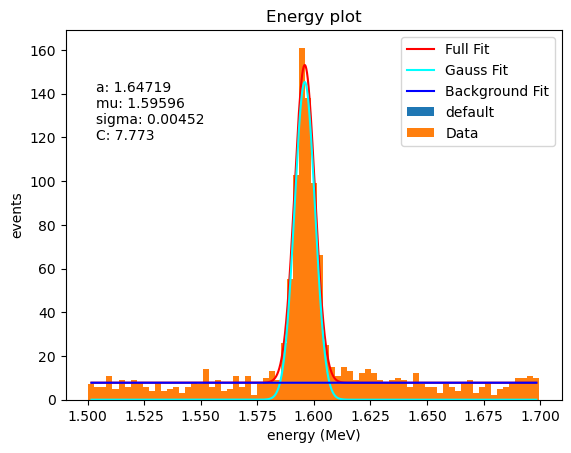

        Fitting output      
a: 1.6472 ± 0.0323
mu: 1.5960 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 7.7730 ± 0.4667
ns = 1.6471888240374195
nb = 1.554600751309672
True ns = 620.0247178825308
True nb = 585.1732832233282


In [369]:
# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)


# fitting
p0 = [150, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

print(p0)
popt, pcov = curve_fit(gauss_bck_norm, centres, hist, p0, maxfev = 5000000)
plot_fit(gauss_bck_norm, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss_norm, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss_norm, emin, emax, args = (popt[0], popt[1], popt[2]))
nb0 = quad(bck, emin, emax, args = popt[-1])
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))

print('True ns = {}'.format(ns0[0]/bin_width))
print('True nb = {}'.format(nb0[0]/bin_width))